In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [9]:
job = (
    pl.scan_csv("job.csv")
    .select(
        "monthly_salary_code",
        "degree_code",
        "work_year_code",
        "company_size_code",
        "economic_area_code",
        "city_level_code",
        "skill_type_code",
        "part",
    )
    .collect()
)
job.head(3)

job_part = job.filter(pl.col("part") == "东部").drop("part")

In [10]:
def cal_rules(job_part: pl.DataFrame) -> pd.DataFrame:
    """Calculate association rules for the job data."""
    job_trans = tuple(tuple(x for x in row if x is not None) for row in job_part.rows())
    encoder = TransactionEncoder()
    data_transformed = encoder.fit_transform(job_trans)
    df_transformed = pd.DataFrame(data_transformed, columns=encoder.columns_)  # type: ignore[reportArgumentType]
    frequent_items = apriori(df_transformed, min_support=0.1, use_colnames=True)
    rules = association_rules(frequent_items, metric="confidence", min_threshold=0.7)
    rules = rules.sort_values(by="confidence", ascending=False)

    rules["antecedents"] = ["->".join(list(x)) for x in rules["antecedents"]]
    rules["consequents"] = ["->".join(list(x)) for x in rules["consequents"]]

    rules[
        ["antecedent support", "consequent support", "support", "confidence", "lift"]
    ] = rules[
        ["antecedent support", "consequent support", "support", "confidence", "lift"]
    ].round(4)

    return rules


rules_east = cal_rules(job.filter(pl.col("part") == "东部").drop("part"))
rules_west = cal_rules(job.filter(pl.col("part") == "西部").drop("part"))
rules_north = cal_rules(job.filter(pl.col("part") == "东北").drop("part"))
rules_middle = cal_rules(job.filter(pl.col("part") == "中部").drop("part"))
rulues_all = cal_rules(job.drop("part"))

# write the rules to xlsx, different sheets for different regions
with pd.ExcelWriter("job_rules.xlsx") as writer:
    rules_east.to_excel(writer, sheet_name="东部", index=False)
    rules_west.to_excel(writer, sheet_name="西部", index=False)
    rules_north.to_excel(writer, sheet_name="东北", index=False)
    rules_middle.to_excel(writer, sheet_name="中部", index=False)
    rulues_all.to_excel(writer, sheet_name="全国", index=False)

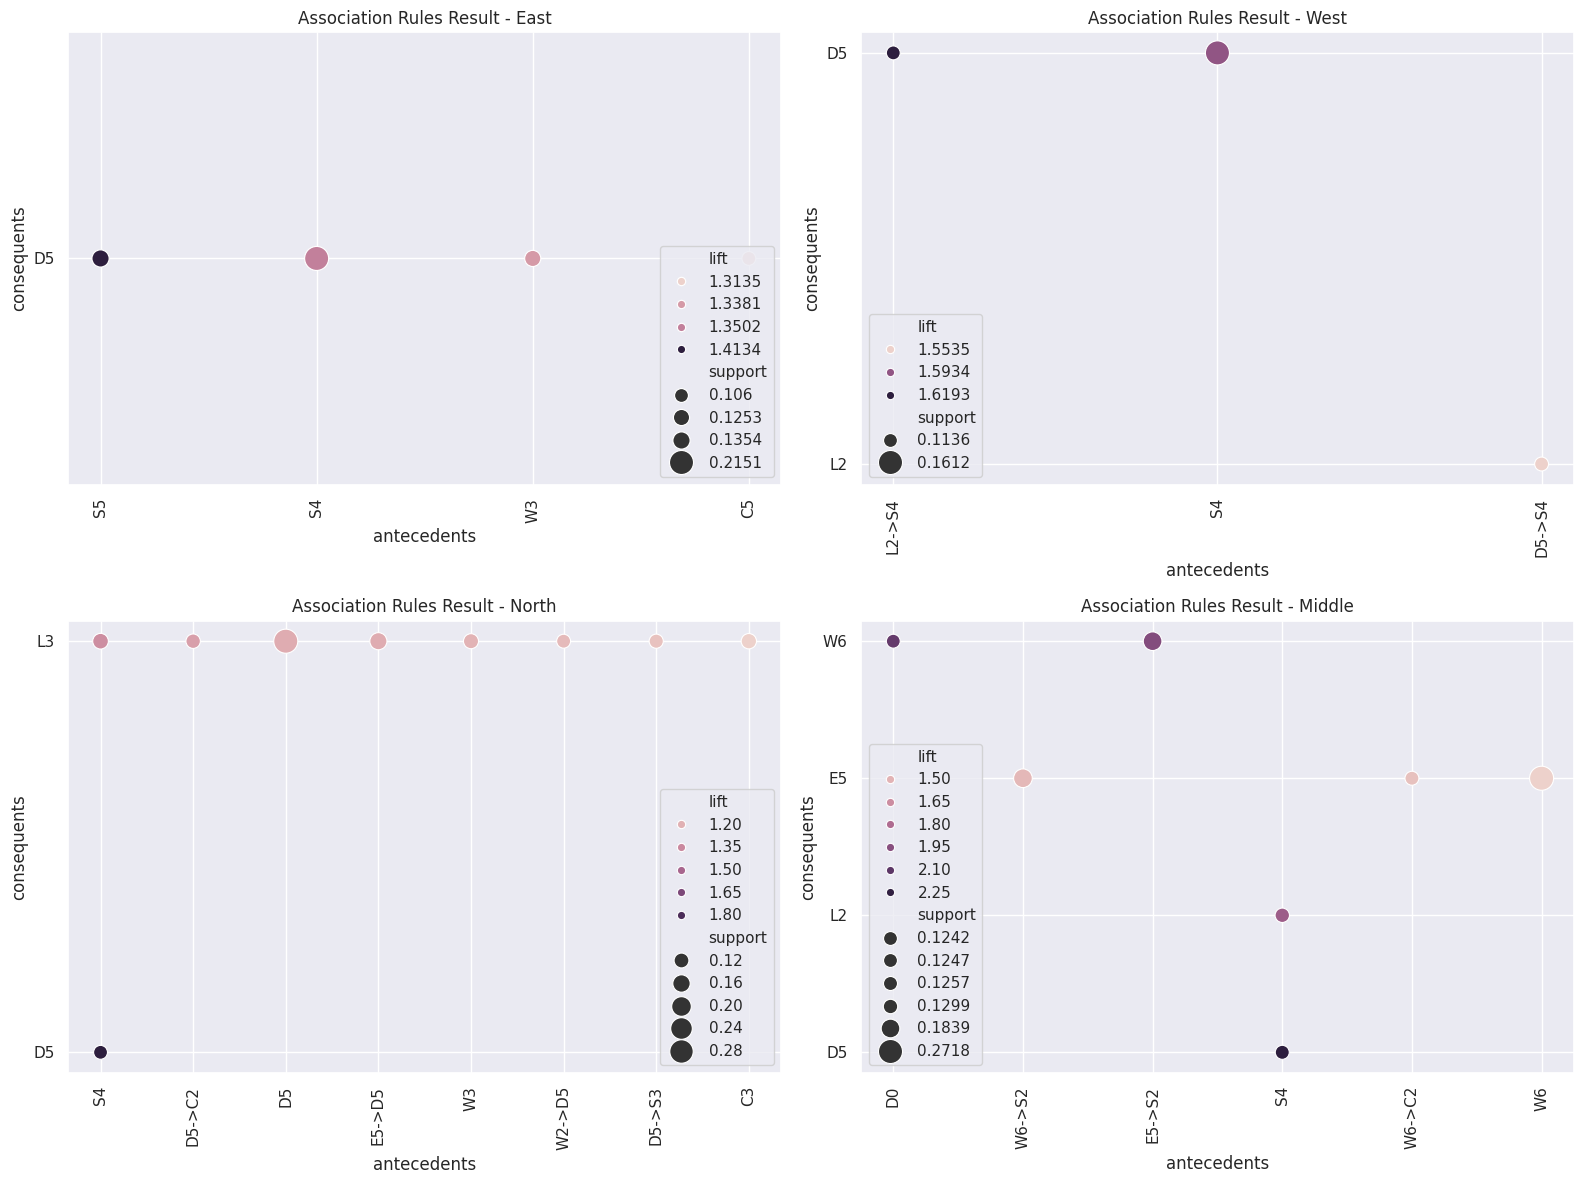

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
sns.set_theme(style="darkgrid")

# Store your data and titles in a dictionary
data_dict = {
    "Association Rules Result - East": rules_east,
    "Association Rules Result - West": rules_west,
    "Association Rules Result - North": rules_north,
    "Association Rules Result - Middle": rules_middle,
}

# Loop over your data and titles
for i, (title, data) in enumerate(data_dict.items()):
    ax = axs[i // 2, i % 2]  # Determine the correct subplot
    sns.scatterplot(
        data=data,
        x="antecedents",
        y="consequents",
        hue="lift",
        size="support",
        sizes=(100, 300),
        ax=ax,
    )
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=90)
    if ax in (axs[0, 0], axs[1, 0]):
        ax.legend(loc="lower right")
    else:
        ax.legend(loc="lower left")

plt.tight_layout()
plt.savefig("association_rules.svg")
plt.show()

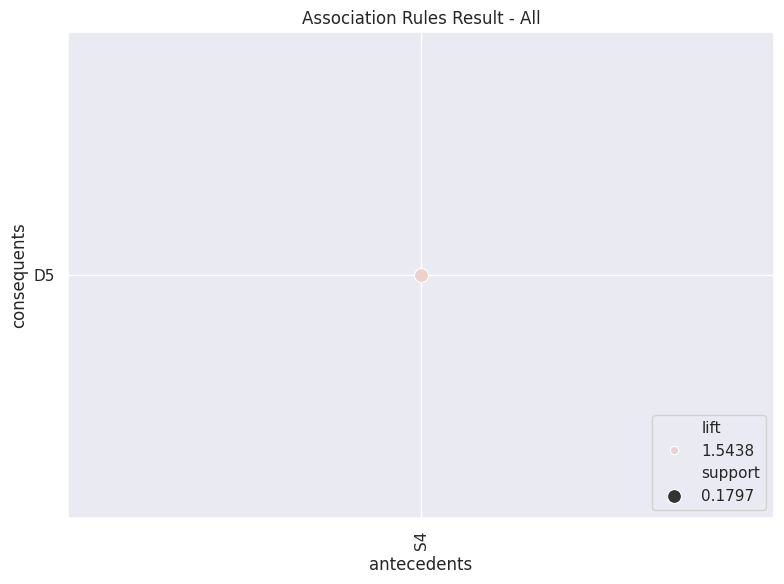

In [12]:
# plot rule_all
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rulues_all,
    x="antecedents",
    y="consequents",
    hue="lift",
    size="support",
    sizes=(100, 300),
)
plt.title("Association Rules Result - All")
plt.xticks(rotation=90)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("association_rules_all.svg")
plt.show()

In [23]:
def cal_rules_of_most_lift(job_part: pl.DataFrame) -> pd.DataFrame:
    """Find rules for the job data with specific consequents, sorted by lift."""
    job_trans = tuple(tuple(x for x in row if x is not None) for row in job_part.rows())
    te = TransactionEncoder()
    data_transformed = te.fit_transform(job_trans)
    df_transformed = pd.DataFrame(data_transformed, columns=te.columns_)  # type: ignore[reportArgumentType]
    frequent_items = apriori(df_transformed, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_items, metric="confidence", min_threshold=0.01)
    rules = rules[rules["consequents"].apply(lambda x: "S5" in x)]
    rules = rules.sort_values(by=["lift", "confidence"], ascending=False)

    rules["antecedents"] = ["->".join(list(x)) for x in rules["antecedents"]]
    rules["consequents"] = ["->".join(list(x)) for x in rules["consequents"]]

    rules[
        ["antecedent support", "consequent support", "support", "confidence", "lift"]
    ] = rules[
        ["antecedent support", "consequent support", "support", "confidence", "lift"]
    ].round(4)

    return rules[rules["consequents"] == "S5"][:5]


rules_west_lift = cal_rules_of_most_lift(
    job.filter(pl.col("part") == "西部").drop("part")
)
rules_west_lift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
7417,L2->E5->D5->C6,S5,0.0203,0.0583,0.0105,0.5165,8.8653,0.009308,1.947692,0.905596
5487,E5->D5->C6,S5,0.0297,0.0583,0.0141,0.4737,8.1307,0.012333,1.789308,0.903842
5555,L2->E5->C6,S5,0.0252,0.0583,0.0116,0.4602,7.8988,0.010138,1.744537,0.895999
5528,L2->D5->C6,S5,0.0348,0.0583,0.0150,0.4295,7.3720,0.012927,1.650692,0.895536
2100,E5->C6,S5,0.0379,0.0583,0.0156,0.4118,7.0678,0.013414,1.600960,0.892377
